In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

random.seed(1234)   
np.random.seed(1234)


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                save_to, epoch = 2,
                dense_layers_unit_array=[],
                patience=10, epoch_denominator=10.,
                isConstantLearningRate=False, learningRate=0.001,
                activation="relu", isBatchNormalized=False):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("epoch:",epoch)
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))        
        
    print("patience:",patience,"; epoch_denominator:",epoch_denominator)
    print("isConstantLearningRate:",isConstantLearningRate,"; learningRate:",learningRate) 
    print("isBatchNormalized:",isBatchNormalized)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, x_train.shape[1]))
        model.summary()
        tf.keras.utils.plot_model(model)

        opt_adam = keras.optimizers.Adam(learning_rate=learningRate)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
            
        if isConstantLearningRate:  
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
        else:  
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))
            
        model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

        
    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))


In [4]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 1
dense_layer[0]; unit:512
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 1,916,420
Trainable params: 1,916,420
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0

Epoch 00025: early stopping


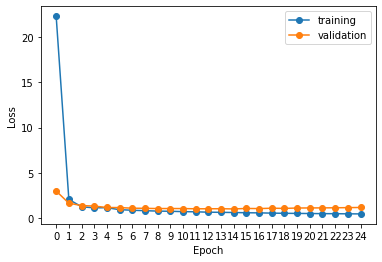

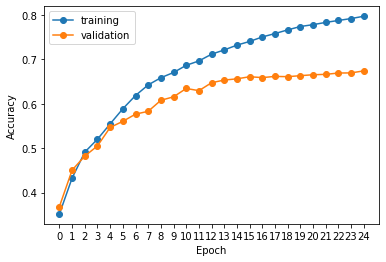

251/251 [==============================] - 2s 6ms/step - loss: 1.1588 - accuracy: 0.6875 - precision: 0.7608 - recall: 0.6241

Test Acc. 68.75%
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1978
           1       0.74      0.68      0.71      1957
           2       0.86      0.69      0.77      2069
           3       0.55      0.74      0.63      2011

   micro avg       0.69      0.69      0.69      8015
   macro avg       0.71      0.69      0.69      8015
weighted avg       0.71      0.69      0.69      8015
 samples avg       0.69      0.69      0.69      8015



In [6]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512]
                    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               131328    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 2,046,724
Trainable params: 

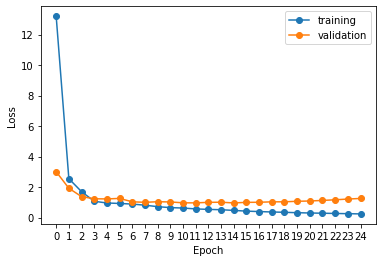

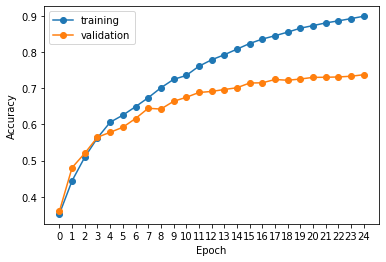

251/251 [==============================] - 2s 6ms/step - loss: 1.2255 - accuracy: 0.7493 - precision: 0.7839 - recall: 0.7125

Test Acc. 74.93%
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1978
           1       0.76      0.77      0.76      1957
           2       0.81      0.80      0.81      2069
           3       0.73      0.69      0.71      2011

   micro avg       0.75      0.75      0.75      8015
   macro avg       0.75      0.75      0.75      8015
weighted avg       0.75      0.75      0.75      8015
 samples avg       0.75      0.75      0.75      8015



In [8]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256]
                    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
__________________

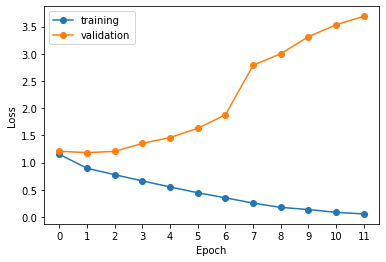

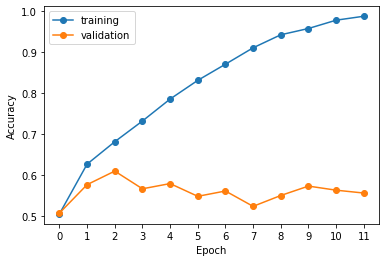

251/251 [==============================] - 2s 6ms/step - loss: 5.6787 - accuracy: 0.5604 - precision: 0.5824 - recall: 0.5298

Test Acc. 56.04%
              precision    recall  f1-score   support

           0       0.83      0.34      0.49      1978
           1       0.81      0.42      0.55      1957
           2       0.84      0.54      0.66      2069
           3       0.39      0.93      0.54      2011

   micro avg       0.56      0.56      0.56      8015
   macro avg       0.72      0.56      0.56      8015
weighted avg       0.72      0.56      0.56      8015
 samples avg       0.56      0.56      0.56      8015



In [13]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256],
                     isBatchNormalized=True
                    )

In [6]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1024,512]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:1024
dense_layer[1]; unit:512
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 1024)              3828736   
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               524800    
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 4,

ResourceExhaustedError: in user code:

    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/mirrored_strategy.py:628 _call_for_each_replica
        return mirrored_run.call_for_each_replica(
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/mirrored_run.py:93 call_for_each_replica
        return _call_for_each_replica(strategy, fn, args, kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/mirrored_run.py:234 _call_for_each_replica
        coord.join(threads)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/training/coordinator.py:389 join
        six.reraise(*self._exc_info_to_raise)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/six.py:719 reraise
        raise value
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/training/coordinator.py:297 stop_on_exception
        yield
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/mirrored_run.py:323 run
        self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:604 apply_gradients
        self._create_all_weights(var_list)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:783 _create_all_weights
        self._create_slots(var_list)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/adam.py:129 _create_slots
        self.add_slot(var, 'v')
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:847 add_slot
        weight = tf_variables.Variable(
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:244 _variable_v2_call
        return previous_getter(
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2186 create_colocated_variable
        return next_creator(**kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/shared_variable_creator.py:69 create_new_variable
        v = next_creator(**kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2083 creator_with_resource_vars
        created = self._create_variable(next_creator, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/mirrored_strategy.py:486 _create_variable
        return distribute_utils.create_mirrored_variable(
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_utils.py:311 create_mirrored_variable
        value_list = real_mirrored_creator(**kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/mirrored_strategy.py:481 _real_mirrored_creator
        v = next_creator(**kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:712 variable_capturing_scope
        v = UnliftedInitializerVariable(
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:227 __init__
        initial_value = initial_value()
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/initializers/initializers_v2.py:139 __call__
        return super(Zeros, self).__call__(shape, dtype=_get_dtype(dtype), **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/init_ops_v2.py:154 __call__
        return array_ops.zeros(shape, dtype)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2819 wrapped
        tensor = fun(*args, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:2880 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/array_ops.py:239 fill
        result = gen_array_ops.fill(dims, value, name=name)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/ops/gen_array_ops.py:3348 fill
        _ops.raise_from_not_ok_status(e, name)
    /home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:6862 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[3738,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]
